In [ ]:
# Author: Eli Bolotin
# Website: www.ebolotin.com

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt

# custom package
from image_utils import *

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Model, Sequential, models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

np.random.seed(6)

Using TensorFlow backend.


In [2]:
# # verify if tensorflow is running with GPU
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# # check if keras is using GPU
print(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


## Define data, sample size, and image parameters

In [3]:
# define datasets
train_data_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train/"
test_data_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test/"
pred_data_dir = "/kaggle/input/intel-image-classification/seg_pred/"
 
# define datasets and sample size
num_train_samples = count_samples(train_data_dir)
num_test_samples = count_samples(test_data_dir)
num_pred_samples = count_samples(pred_data_dir)

# define image dimensions
img_width, img_height = 150, 150
img_target_size = (img_width, img_height)

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

## Review training images and classifications

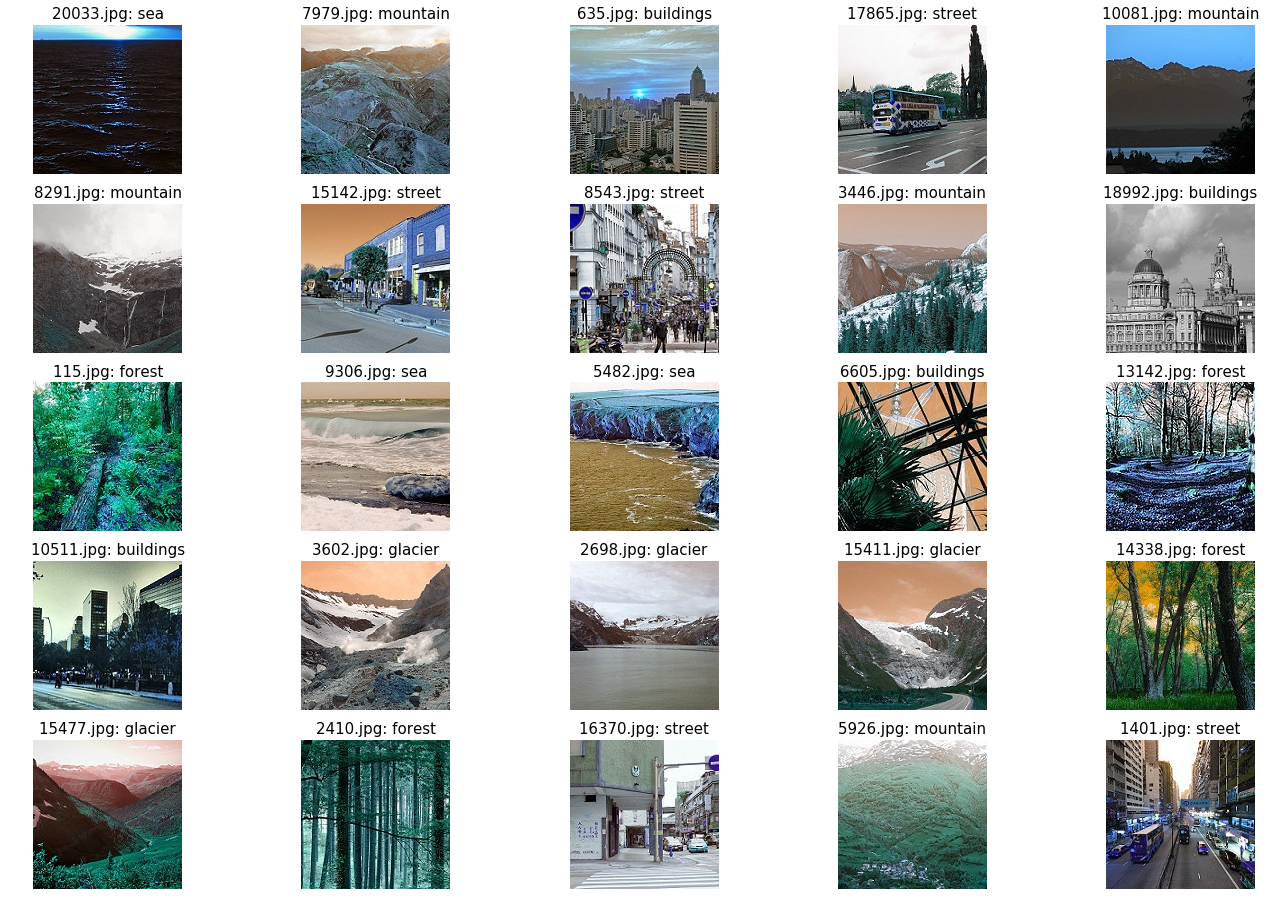

In [4]:
training_imgs, labeled_training_imgs = label_images(train_data_dir, '.jpg')
plot_images(training_imgs, labeled_training_imgs)

## Define model hyperparameters and data generators

In [5]:
# define model hyperparameters
epochs = 5
batch_size = 64
pred_batch_size = 49
neurons_per_layer = [2048, 1024, 512]
dropout = 0.5
n_classes = 6
patience = 3

# specify image augmentation
img_augmentation = ImageDataGenerator(preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True)

# prepare train/test data generators
train_data = img_augmentation.flow_from_directory(
    train_data_dir,
    target_size = img_target_size,
    batch_size = batch_size,
    class_mode = 'categorical')

test_data = img_augmentation.flow_from_directory(
    test_data_dir,
    target_size = img_target_size,
    batch_size = batch_size,
    class_mode = 'categorical')

pred_data = img_augmentation.flow_from_directory(
    pred_data_dir,
    target_size = img_target_size,
    batch_size = pred_batch_size,
    color_mode = "rgb",
    class_mode = None,
    shuffle = False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


## Create Label Map

In [6]:
# Make label map
label_map = {v: k for k, v in train_data.class_indices.items()}

## Create model

In [7]:
# specify base model and freeze weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# create model function
def create_model(base_model, dropout, neurons_per_layer, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.Flatten()(x)
    
    for num_neurons in neurons_per_layer:
        x = layers.Dense(num_neurons, activation='relu')(x) 
    
    x = layers.Dropout(dropout)(x)

    classifications = layers.Dense(num_classes, activation='softmax')(x) 
    model = Model(inputs=base_model.input, outputs=classifications)
    
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['acc'])

    return model

# instantiate model
model = create_model(base_model, dropout=dropout, neurons_per_layer=neurons_per_layer, num_classes=n_classes)

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


## Train model

In [8]:
callbacks = [EarlyStopping(monitor='val_acc', patience=patience),
             ModelCheckpoint(filepath='resnet_iic_kaggle.h5', monitor='val_acc', save_best_only=True)]

# train model
history = model.fit_generator(
    train_data,
    steps_per_epoch = num_train_samples // batch_size,
    validation_data = test_data,
    validation_steps = num_test_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    verbose = 1)

Epoch 1/5
219/219 [==============================] - 120s 546ms/step - loss: 1.3709 - acc: 0.7570 - val_loss: 0.5199 - val_acc: 0.8179
Epoch 2/5
219/219 [==============================] - 102s 464ms/step - loss: 0.4547 - acc: 0.8425 - val_loss: 0.5406 - val_acc: 0.8247
Epoch 3/5
219/219 [==============================] - 101s 463ms/step - loss: 0.4151 - acc: 0.8578 - val_loss: 0.3956 - val_acc: 0.8556
Epoch 4/5
219/219 [==============================] - 111s 505ms/step - loss: 0.3810 - acc: 0.8689 - val_loss: 0.4579 - val_acc: 0.8601
Epoch 5/5
219/219 [==============================] - 126s 574ms/step - loss: 0.3557 - acc: 0.8763 - val_loss: 0.4227 - val_acc: 0.8641


### Download model for offline use

In [9]:
# from IPython.display import FileLink
# FileLink("resnet_iic_kaggle.h5")

### Load model (for offline use)

In [10]:
# model.load_weights('resnet_iic_kaggle.h5')

## Plot training vs val accuracy

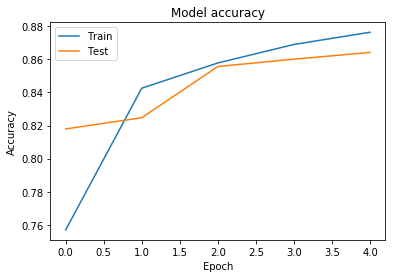

In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Make predictions on test data (holdout dataset)

In [12]:
test_score = model.evaluate_generator(test_data,
    steps = num_test_samples // batch_size,
    verbose=1)

print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

46/46 [==============================] - 18s 382ms/step - loss: 0.4296 - acc: 0.8716
Test loss 0.4296, accuracy 87.16%


## Generate prediction images (as np.array) and associated mlabels

In [13]:
pred_imgs, pred_img_labels = label_images(pred_data_dir, '.jpg')

## Make and plot predictions for sample of 25 images

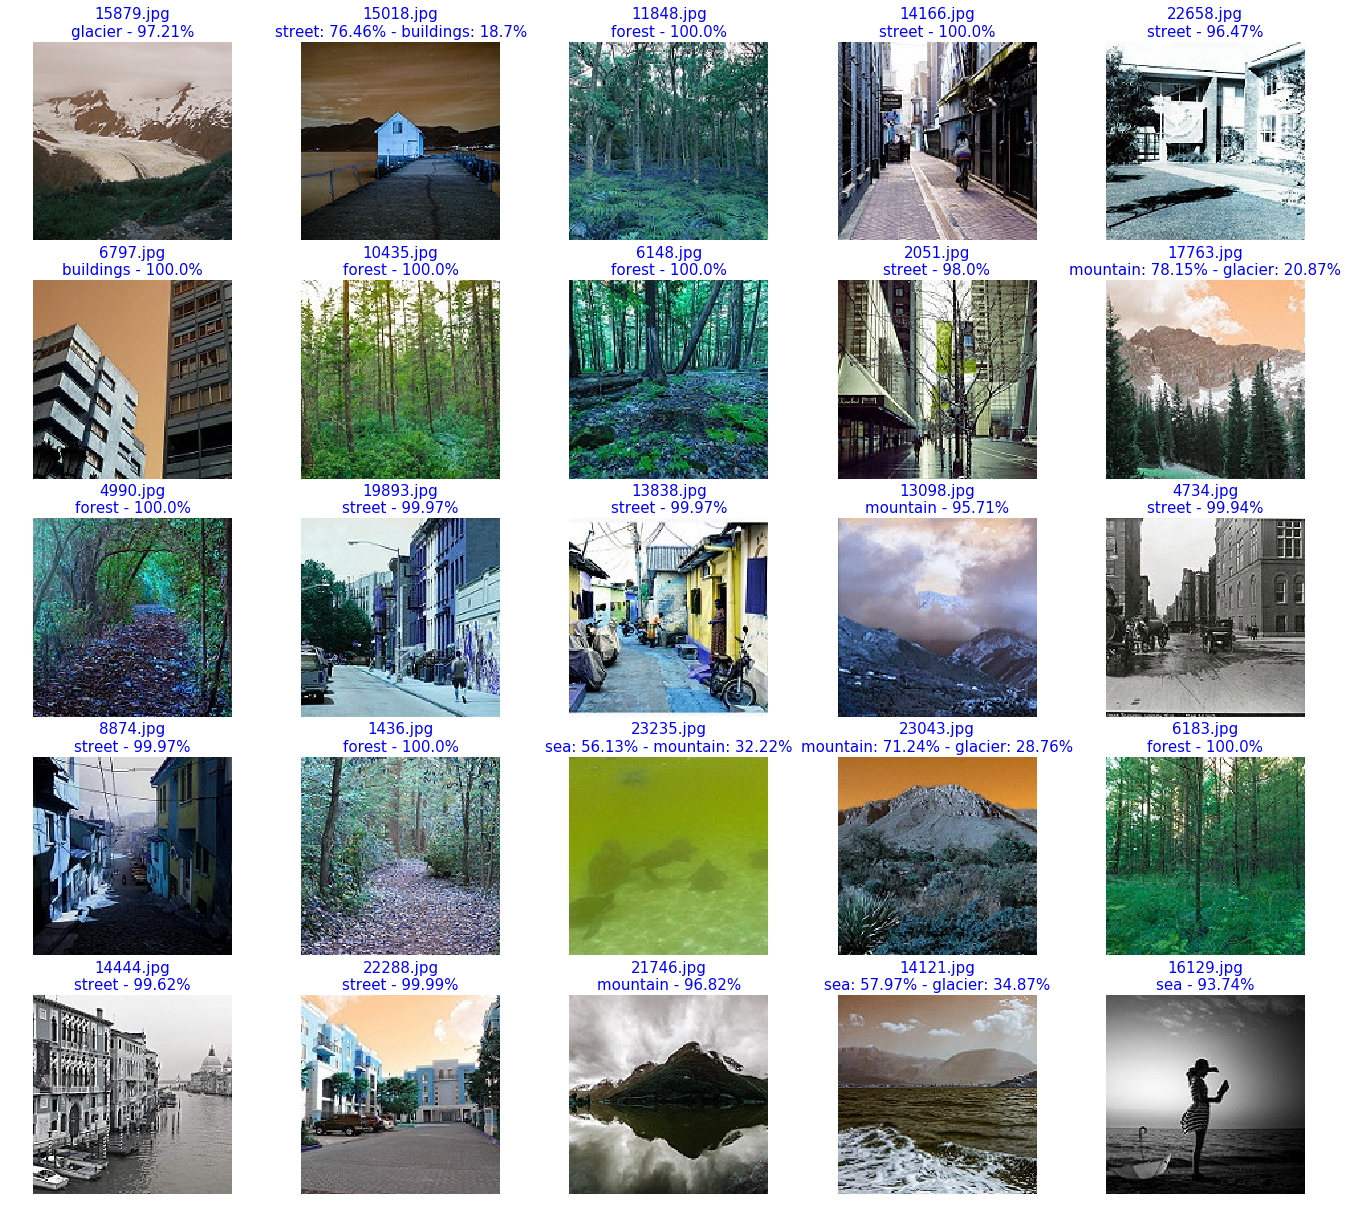

In [14]:
plot_predictions(pred_data_dir, pred_imgs, pred_img_labels, model, label_map)

## Make predictions for all images

In [15]:
pred_data.reset()
predictions = model.predict_generator(pred_data,
    steps = num_pred_samples // pred_batch_size,
    verbose=1)

149/149 [==============================] - 48s 323ms/step


## Compute probabilities and classes

In [16]:
filenames = pred_data.filenames
predicted_class = [label_map[top_pred] for top_pred in predictions.argmax(axis=1)]
predicted_prob = predictions.max(axis=1).tolist()

## Create dataframe of predictions

In [17]:
data = {'file': filenames, 'prob': predicted_prob, 'class': predicted_class}
predictions_df = pd.DataFrame(data=data)

## View dataframe of predictions

In [18]:
predictions_df

,file,prob,class
0,seg_pred/10004.jpg,0.983471,street
1,seg_pred/10005.jpg,0.932762,mountain
2,seg_pred/10012.jpg,0.993731,street
3,seg_pred/10013.jpg,0.635475,glacier
4,seg_pred/10017.jpg,0.518190,mountain
...,...,...,...
7296,seg_pred/9988.jpg,0.959740,street
7297,seg_pred/9992.jpg,1.000000,forest
7298,seg_pred/9993.jpg,0.999347,mountain
7299,seg_pred/9995.jpg,1.000000,forest
